# Generate Plots from the models output


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('default')
import os 
import sys
sys_path = sys.path.copy()
sys.path.append('../')
import utils.utils as utils
sys.path = sys_path
plot_dir = '../output/plots/'

/opt/homebrew/Caskroom/miniforge/base/envs/transformers_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/myra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
output_dir='../output/'

In [3]:
# Code for pretty plots
# https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
import seaborn as sns
label_text_color='#555555'
text_color="black"
accent_color="lightgrey"
sns.set(font="Franklin Gothic Book",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": accent_color,
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": text_color,
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": text_color,
 "xtick.bottom": True,
 "xtick.color": accent_color,
 "xtick.labelcolor": label_text_color,
 "xtick.direction": "out",
 "xtick.labelsize": 18,
 "xtick.top": False,
 "ytick.color": label_text_color,
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})
sns.set_context("notebook", rc={"font.size":24,
                                "axes.titlesize":26,
                                "axes.labelsize":26,
                                "axes.xticksize":26})
tu_c1='#004E8A'

In [4]:
COLORS = ['#004E8A', '#B90F22', '#FFE05C', '#F5A300', '#00715E', '#50B695', '#C9308E', '#6A8B22']
COLORS = ['#004E8A', '#FFE05C', '#F5A300', '#50B695', '#581845', '#E9503E', '#99C000', '#00715E', '#C9308E', '#6A8B22']

# 1c (adapt), 4d, 6a (lora-q), 7b (lora-v), 10a (adapt-emo), 3d, 3a, 9c
col_by_method = {'gate_lora_query':'#FFE05C', 'gate_lora_value':'#F5A300', 'gate_adapter-distress':'#004E8A', 'gate_adapter-empathy':'#004E8A', 'gate_adapter-emotion':'#50B695', 'gate_prefix':'#E9503E'}
def get_color(i, method_name=None):
    """Either get color by method name or i

    Args:
        i (_type_): _description_
        method_name (str, optional): _description_. Defaults to ''.
    """
    col = '#000000'
    if method_name and method_name in col_by_method.keys():
        col = col_by_method[method_name]
    else:
        i = i % len(COLORS)  # if index too long, start with color from beginning again
        col = COLORS[i]
    
    return col

get_color(6)

'#99C000'

In [5]:
def color_per_method(method_name):
    method_names = ['gate_adapter-distress', 'gate_lora_query', 'gate_lora_value', 'gate_prefix', 'gate_adapter-empathy', 'gate_adapter-bert-base-uncased-pf-emotion']
    this_colors = COLORS[:len(method_names)]  # cut off color list
    color_dict = {m: c for m, c in zip(method_names, this_colors)}
    if method_name not in color_dict.keys():
        return COLORS[-1]
    return color_dict[method_name]

## Generate and show plots for the models

In [6]:
def plot_gate_per_layer(model_name, model_display_name, task_name, gates=None):
    if gates is None:
        gates = pd.read_csv(f'../output/{model_name}/{task_name}/gates.csv')
    encoder_layers = sorted(set(gates['encoder_layer']))
    # get eval and train of last epoch while in train
    last_train = gates[(gates['split'] == 'train') & (gates['epoch'] == max(gates['epoch'])) & (gates['is_in_train'] == True)].reset_index()
    after_train_eval = gates[(gates['split'] == 'eval') & (gates['is_in_train'] == False)].reset_index()
    after_train_test = gates[(gates['split'] == 'test') & (gates['is_in_train'] == False)].reset_index()

    data = after_train_test
    print(len(data) / 12)
    data

    encoder_layers = sorted(set(gates['encoder_layer']))
    # get eval and train of last epoch while in train
    last_train = gates[(gates['split'] == 'train') & (gates['epoch'] == max(gates['epoch'])) & (gates['is_in_train'] == True)].reset_index()
    after_train_eval = gates[(gates['split'] == 'eval') & (gates['is_in_train'] == False)].reset_index()
    after_train_test = gates[(gates['split'] == 'test') & (gates['is_in_train'] == False)].reset_index()

    show_plot_crit = lambda key: len(gate_per_set[key]) > 0 # criterion to not show the plot for the data set, here: if dataset not used / df is empty
    gate_per_set = {'train':last_train, 'eval':after_train_eval, 'test':after_train_test}
    count_data_available = sum([1 for key in gate_per_set.keys() if show_plot_crit(key)])

    idx = 0
    for key in gate_per_set.keys():
        if show_plot_crit(key) and key=='test':
            dataset = gate_per_set[key]

            gating_cols = [col for col in dataset.columns if 'gate' in col]
            grouped_mean = dataset.groupby(['encoder_layer']).agg({col: 'mean' for col in gating_cols})
            grouped_std = dataset.groupby(['encoder_layer']).agg({col: 'std' for col in gating_cols})
            print('grouped mean')
            display(grouped_mean)
            print('Grouped std')
            display(grouped_std)
            bar_width = 2
            width = bar_width * (len(gating_cols)) + bar_width
            x = grouped_mean.index.to_numpy() * width
            this_colors = COLORS
            if len(this_colors) < len(gating_cols):  # if not enough colors in the list
                this_colors = [COLORS[i] if i < len(COLORS) else '#000000' for i in range(len(gating_cols))]

            fig, axs = plt.subplots()
            fig.set_figwidth(len(grouped_mean))
            fig.set_figheight(5.5)
            for idx, col in enumerate(gating_cols):
                y_pos = x + idx * bar_width
                #color_i = this_colors[idx]
                color_i = color_per_method(col)
                label_i = col[5:].replace('-', ' ').replace('_', ' ')
                axs.bar(x=y_pos, yerr=grouped_std[col], height=grouped_mean[col], width=bar_width, label=label_i, color=color_i)#, 'gate_lora_value', 'gate_lora_query', 'gate_adapters']], label=['gate_prefix', 'gate_lora_value', 'gate_lora_query', 'gate_adapters'])
            
            axs.set_xlabel('Encoder Layer')
            axs.set_xticklabels(grouped_mean.index.to_numpy() + 1)
            axs.set_xticks(x + ((len(gating_cols)-1) * bar_width)/2)
            #axs.set_title(f'{key} data set')
            axs.set_xlim(x[0]-bar_width/2, x[-1] + ((len(gating_cols)-1) * bar_width) + bar_width/2)
            axs.set_ylim(0,1)
            axs.set_ylabel('Mean Gate Value')
            #axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            legend_col = int(len(gating_cols) / 2)
            print(legend_col)
            axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), prop={'size': 14}, ncol=legend_col, fancybox=True)

            #fig.suptitle()
            axs.set_title(f'{model_display_name}: Mean Gate Values for all Encoder Layers', pad=80)
            fig.tight_layout()
            title = f'{key}/gating_layers'
            fig.savefig(f'{output_dir}/{model_name}/{model_name}_{task_name}_' + title.replace('/', '_') + '.pdf', bbox_inches='tight', dpi=plt.gcf().dpi)
            #plt.close()
            #fig.show()


795.0
grouped mean


,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.937872,0.978592,0.934723,0.167803
1,0.965471,0.988600,0.775680,0.169069
2,0.959203,0.996376,0.965759,0.126931
3,0.946955,0.991472,0.904099,0.174237
4,0.902404,0.995068,0.890962,0.073186
5,0.820070,0.991473,0.946501,0.376871
6,0.855913,0.994433,0.962728,0.438555
7,0.585575,0.960529,0.965402,0.464516
8,0.655493,0.982548,0.646748,0.577377


Grouped std


,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.016499,0.006187,0.012827,0.030441
1,0.007336,0.003230,0.049196,0.036328
2,0.006858,0.000800,0.008157,0.030198
3,0.009063,0.001575,0.012619,0.037412
4,0.010171,0.000876,0.023501,0.016212
5,0.029693,0.001433,0.007015,0.035608
6,0.015984,0.000933,0.004698,0.032824
7,0.047894,0.009850,0.004958,0.035721
8,0.048721,0.005407,0.043185,0.078261


/var/folders/kx/k45gj1_52ns5bsbjyn403cs00000gn/T/ipykernel_9998/3218846477.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(grouped_mean.index.to_numpy() + 1)
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


2


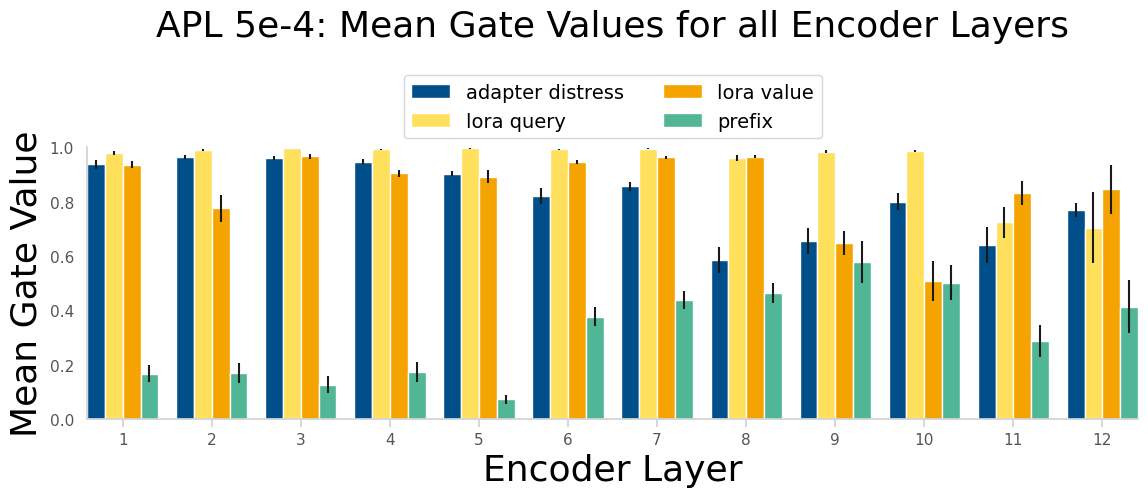

In [7]:
model_name = 'unipelt_apl_5e-4'
model_display_name = 'APL 5e-4'

task_name = 'distress'
gates = pd.read_csv(f'../output/{model_name}/{task_name}/gates.csv')
plot_gate_per_layer(model_name, model_display_name, task_name, gates)

795.0
grouped mean


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,,
0,0.411582,0.899712,0.826703,0.804158,0.744371
1,0.535805,0.905938,0.878197,0.786128,0.848624
2,0.460086,0.844232,0.952771,0.787053,0.734692
3,0.399683,0.874730,0.936003,0.814643,0.664267
4,0.460013,0.859320,0.953304,0.724647,0.551987
5,0.463813,0.789484,0.932375,0.802340,0.628821
6,0.501511,0.889508,0.950603,0.832621,0.776008
7,0.332917,0.751767,0.925093,0.805907,0.669778
8,0.478050,0.816941,0.932074,0.769563,0.752633


Grouped std


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,,
0,0.014270,0.022702,0.030326,0.035396,0.042203
1,0.017443,0.017336,0.026507,0.032405,0.030842
2,0.017702,0.019389,0.010551,0.027142,0.031210
3,0.018307,0.015682,0.011946,0.022626,0.018556
4,0.016933,0.014263,0.007679,0.018424,0.013040
5,0.022875,0.019300,0.009156,0.012650,0.016822
6,0.022071,0.010777,0.008020,0.012533,0.017457
7,0.021321,0.020342,0.010459,0.015768,0.015852
8,0.029144,0.017585,0.009793,0.019344,0.028114


2


/var/folders/kx/k45gj1_52ns5bsbjyn403cs00000gn/T/ipykernel_9998/3218846477.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(grouped_mean.index.to_numpy() + 1)


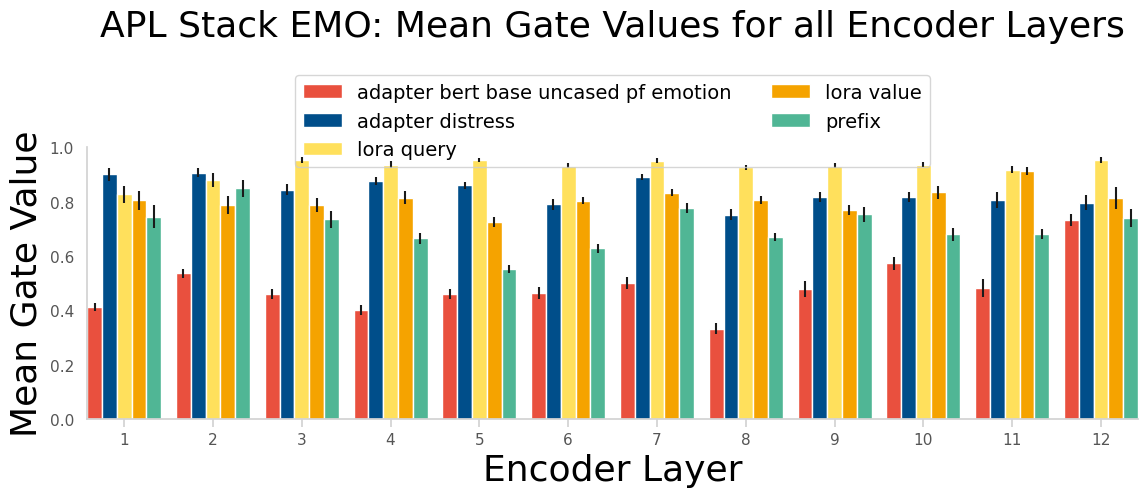

In [8]:
model_name = 'unipelt_apl_stack'
model_display_name = 'APL Stack EMO'

task_name = 'distress'
gates = pd.read_csv(f'../output/{model_name}/{task_name}/gates.csv')
plot_gate_per_layer(model_name, model_display_name, task_name, gates)

795.0
grouped mean


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
encoder_layer,,
0,0.552921,0.912311
1,0.594569,0.908782
2,0.380058,0.914617
3,0.315174,0.860132
4,0.440403,0.913799
5,0.453941,0.875093
6,0.567904,0.897527
7,0.426043,0.877620
8,0.323299,0.853664


Grouped std


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
encoder_layer,,
0,0.024618,0.017291
1,0.010032,0.016480
2,0.027367,0.015462
3,0.024810,0.016924
4,0.026794,0.009994
5,0.024680,0.015622
6,0.018809,0.014385
7,0.020456,0.015719
8,0.026333,0.016251


1


/var/folders/kx/k45gj1_52ns5bsbjyn403cs00000gn/T/ipykernel_9998/3218846477.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(grouped_mean.index.to_numpy() + 1)


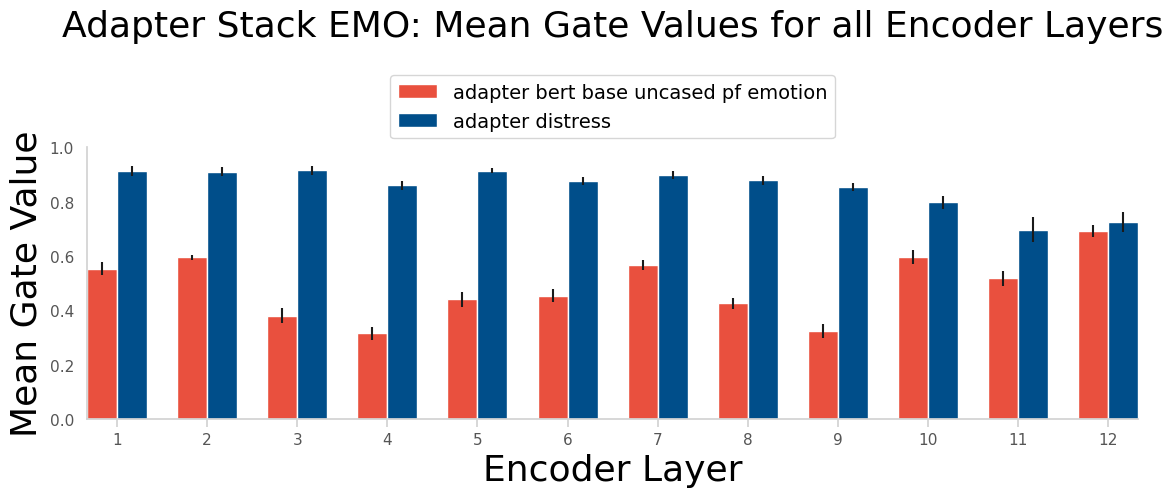

In [9]:
model_name = 'adapter_stack'
model_display_name = 'Adapter Stack EMO'

task_name = 'distress'
gates = pd.read_csv(f'../output/{model_name}/{task_name}/gates.csv')
plot_gate_per_layer(model_name, model_display_name, task_name, gates)

795.0
grouped mean


,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.889017,0.821330,0.781994,0.763172
1,0.896607,0.897133,0.782403,0.863816
2,0.872083,0.961846,0.820640,0.825247
3,0.862049,0.940297,0.812198,0.740731
4,0.840955,0.942901,0.734075,0.735967
5,0.730356,0.923238,0.773261,0.740936
6,0.815468,0.961695,0.872646,0.782976
7,0.659352,0.915605,0.781616,0.761873
8,0.748638,0.954895,0.582333,0.754807


Grouped std


,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.026401,0.032419,0.039792,0.047693
1,0.022188,0.025188,0.034505,0.031942
2,0.023681,0.009765,0.031971,0.039189
3,0.022890,0.014887,0.027334,0.029775
4,0.018158,0.013034,0.024962,0.036862
5,0.021656,0.012470,0.014854,0.022947
6,0.013979,0.006895,0.013685,0.025211
7,0.023257,0.009986,0.015810,0.020775
8,0.021544,0.009063,0.025225,0.033722


2


/var/folders/kx/k45gj1_52ns5bsbjyn403cs00000gn/T/ipykernel_9998/3218846477.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(grouped_mean.index.to_numpy() + 1)


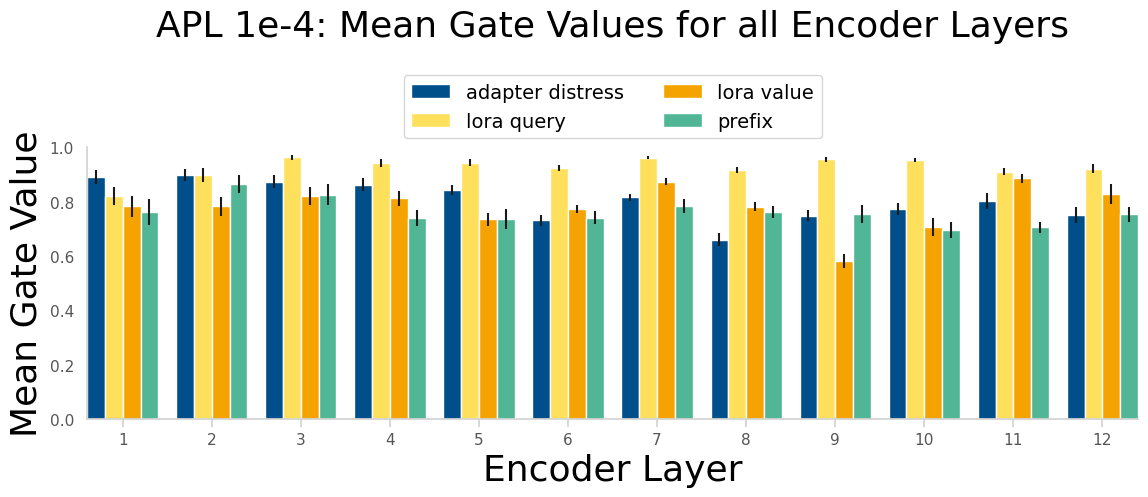

In [10]:
model_name = 'unipelt_apl_1e-4'
model_display_name = 'APL 1e-4'

task_name = 'distress'
gates = pd.read_csv(f'../output/{model_name}/{task_name}/gates.csv')
plot_gate_per_layer(model_name, model_display_name, task_name, gates)

795.0
grouped mean


,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.951837,0.938085,0.819529,0.743936
1,0.965349,0.966797,0.798528,0.842058
2,0.944198,0.993872,0.873110,0.768362
3,0.942215,0.980273,0.914833,0.442200
4,0.913698,0.987328,0.845896,0.325133
5,0.836314,0.984360,0.923261,0.461895
6,0.852482,0.991417,0.944513,0.449463
7,0.778229,0.987301,0.885371,0.682692
8,0.792075,0.989089,0.597358,0.679838


Grouped std


,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.011908,0.011734,0.035466,0.048693
1,0.008086,0.008941,0.036189,0.036568
2,0.011667,0.001681,0.027844,0.040361
3,0.011052,0.005252,0.015933,0.021375
4,0.012669,0.003513,0.028166,0.019626
5,0.019406,0.002741,0.008139,0.026474
6,0.015506,0.001639,0.008701,0.018133
7,0.022163,0.002384,0.015084,0.025978
8,0.022920,0.002415,0.032208,0.064541


2


/var/folders/kx/k45gj1_52ns5bsbjyn403cs00000gn/T/ipykernel_9998/3218846477.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(grouped_mean.index.to_numpy() + 1)


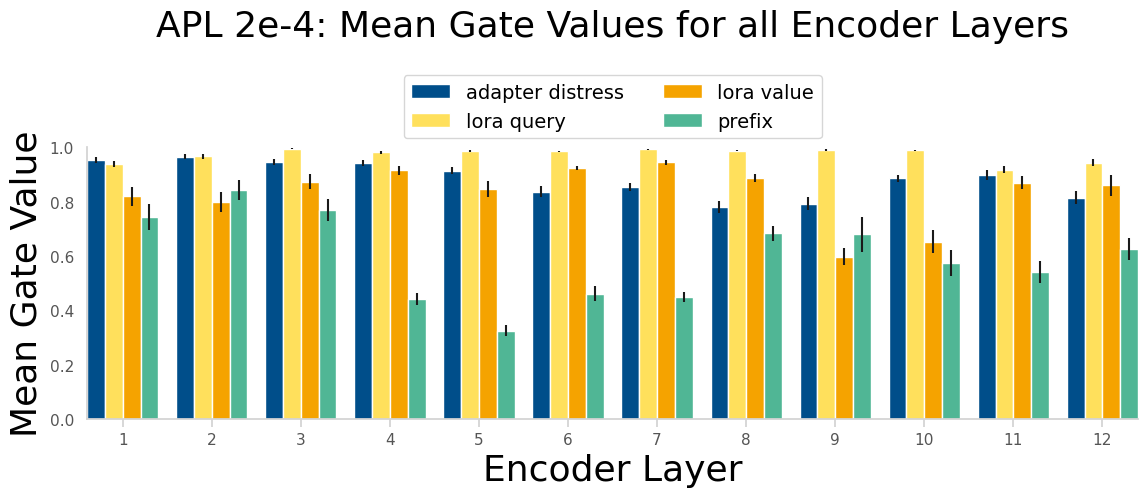

In [11]:
model_name = 'unipelt_apl_2e-4'
model_display_name = 'APL 2e-4'

task_name = 'distress'
gates = pd.read_csv(f'../output/{model_name}/{task_name}/gates.csv')
plot_gate_per_layer(model_name, model_display_name, task_name, gates)

In [12]:
def get_grouped_std_mean(gates, split, display_df=True):
    after_train_test = gates[(gates['split'] == 'test') & (gates['is_in_train'] == False)].reset_index()


    encoder_layers = sorted(set(gates['encoder_layer']))
    # get eval and train of last epoch while in train
    last_train = gates[(gates['split'] == 'train') & (gates['epoch'] == max(gates['epoch'])) & (gates['is_in_train'] == True)].reset_index()
    after_train_eval = gates[(gates['split'] == 'eval') & (gates['is_in_train'] == False)].reset_index()
    after_train_test = gates[(gates['split'] == 'test') & (gates['is_in_train'] == False)].reset_index()

    data = after_train_test

    encoder_layers = sorted(set(gates['encoder_layer']))
    # get eval and train of last epoch while in train
    last_train = gates[(gates['split'] == 'train') & (gates['epoch'] == max(gates['epoch'])) & (gates['is_in_train'] == True)].reset_index()
    after_train_eval = gates[(gates['split'] == 'eval') & (gates['is_in_train'] == False)].reset_index()
    after_train_test = gates[(gates['split'] == 'test') & (gates['is_in_train'] == False)].reset_index()

    show_plot_crit = lambda key: len(gate_per_set[key]) > 0 # criterion to not show the plot for the data set, here: if dataset not used / df is empty
    gate_per_set = {'train':last_train, 'eval':after_train_eval, 'test':after_train_test}
    count_data_available = sum([1 for key in gate_per_set.keys() if show_plot_crit(key)])

    if split in gate_per_set.keys():
        dataset = gate_per_set[split]
        gating_cols = [col for col in dataset.columns if 'gate' in col]
        grouped_mean = dataset.groupby(['encoder_layer']).agg({col: 'mean' for col in gating_cols})
        grouped_std = dataset.groupby(['encoder_layer']).agg({col: 'std' for col in gating_cols})
        if display_df:
            print('grouped mean')
            display(grouped_mean)
            print('Grouped std')
            display(grouped_std)
    return grouped_mean, grouped_std

# Gate mean and std values:

In [13]:
model_name = 'unipelt_apl_5e-4'
model_display_name = 'APL 5e-4'
task_name = 'distress'
print(f'{model_display_name} \t {task_name}')
gates = pd.read_csv(f'../output/{model_name}/{task_name}/gates.csv')
mean, std = get_grouped_std_mean(gates, 'test')
# get max std
max_std = np.max(std.to_numpy().flatten())
np.mean(std.to_numpy().flatten())

APL 5e-4 	 distress
grouped mean


,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.937872,0.978592,0.934723,0.167803
1,0.965471,0.988600,0.775680,0.169069
2,0.959203,0.996376,0.965759,0.126931
3,0.946955,0.991472,0.904099,0.174237
4,0.902404,0.995068,0.890962,0.073186
5,0.820070,0.991473,0.946501,0.376871
6,0.855913,0.994433,0.962728,0.438555
7,0.585575,0.960529,0.965402,0.464516
8,0.655493,0.982548,0.646748,0.577377


Grouped std


,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.016499,0.006187,0.012827,0.030441
1,0.007336,0.003230,0.049196,0.036328
2,0.006858,0.000800,0.008157,0.030198
3,0.009063,0.001575,0.012619,0.037412
4,0.010171,0.000876,0.023501,0.016212
5,0.029693,0.001433,0.007015,0.035608
6,0.015984,0.000933,0.004698,0.032824
7,0.047894,0.009850,0.004958,0.035721
8,0.048721,0.005407,0.043185,0.078261


0.030517809744651275

In [14]:
model_name = 'unipelt_apl_1e-4'
model_display_name = 'APL 1e-4'
task_name = 'distress'
print(f'{model_display_name} \t {task_name}')
gates = pd.read_csv(f'../output/{model_name}/{task_name}/gates.csv')
mean, std = get_grouped_std_mean(gates, 'test')
# get max std
max_std = np.max(std.to_numpy().flatten())
np.mean(std.to_numpy().flatten())

APL 1e-4 	 distress
grouped mean


,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.889017,0.821330,0.781994,0.763172
1,0.896607,0.897133,0.782403,0.863816
2,0.872083,0.961846,0.820640,0.825247
3,0.862049,0.940297,0.812198,0.740731
4,0.840955,0.942901,0.734075,0.735967
5,0.730356,0.923238,0.773261,0.740936
6,0.815468,0.961695,0.872646,0.782976
7,0.659352,0.915605,0.781616,0.761873
8,0.748638,0.954895,0.582333,0.754807


Grouped std


,gate_adapter-distress,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.026401,0.032419,0.039792,0.047693
1,0.022188,0.025188,0.034505,0.031942
2,0.023681,0.009765,0.031971,0.039189
3,0.022890,0.014887,0.027334,0.029775
4,0.018158,0.013034,0.024962,0.036862
5,0.021656,0.012470,0.014854,0.022947
6,0.013979,0.006895,0.013685,0.025211
7,0.023257,0.009986,0.015810,0.020775
8,0.021544,0.009063,0.025225,0.033722


0.023458325141665837

In [15]:
# compare mean of empathy and mean distress for a model
model_name = 'unipelt_apl_1e-4'
model_display_name = 'APL 1e-4'
task_name = 'distress'
gates_emp = pd.read_csv(f'../output/{model_name}/empathy/gates.csv')
gates_dis = pd.read_csv(f'../output/{model_name}/distress/gates.csv')
mean_emp, std_emp = get_grouped_std_mean(gates_emp, 'test', display_df=False)
mean_dis, std_dis = get_grouped_std_mean(gates_dis, 'test', display_df=False)
mean_emp - mean_dis

,gate_adapter-distress,gate_adapter-empathy,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,,
0,NaN,NaN,-0.014135,-0.007522,0.005196
1,NaN,NaN,0.008445,-0.078475,-0.008761
2,NaN,NaN,-0.007766,-0.098364,-0.003795
3,NaN,NaN,-0.011706,-0.057392,-0.009471
4,NaN,NaN,0.004722,-0.068334,-0.094874
5,NaN,NaN,-0.041174,-0.086020,-0.002816
6,NaN,NaN,-0.009015,-0.097993,-0.005982
7,NaN,NaN,-0.031802,-0.064519,0.035184
8,NaN,NaN,-0.028369,0.025677,0.074684


In [16]:
model_name = 'unipelt_apl_2e-4'
model_display_name = 'APL 2e-4'
task_name = 'empathy'
print(f'{model_display_name} \t {task_name}')
gates = pd.read_csv(f'../output/{model_name}/{task_name}/gates.csv')
mean, std = get_grouped_std_mean(gates, 'test')

APL 2e-4 	 empathy
grouped mean


,gate_adapter-empathy,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.964157,0.942746,0.867523,0.755429
1,0.966257,0.979990,0.813348,0.793647
2,0.950485,0.992401,0.778156,0.831106
3,0.947277,0.978578,0.835694,0.649196
4,0.867905,0.993523,0.843958,0.431751
5,0.814715,0.982215,0.950475,0.659591
6,0.828612,0.983756,0.925174,0.709632
7,0.686242,0.968301,0.733483,0.638871
8,0.689085,0.978863,0.724472,0.724714


Grouped std


,gate_adapter-empathy,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,
0,0.009759,0.011261,0.026919,0.056872
1,0.007932,0.005154,0.037067,0.045498
2,0.011964,0.002075,0.030856,0.037665
3,0.011551,0.006307,0.024874,0.027080
4,0.022829,0.001631,0.024353,0.028512
5,0.026581,0.004234,0.009028,0.039724
6,0.017844,0.003561,0.012906,0.028507
7,0.037595,0.006910,0.027529,0.037064
8,0.035728,0.005499,0.032479,0.039107


In [17]:
model_name = 'unipelt_apl_stack'
model_display_name = 'APL Stack EMO'
task_name = 'empathy'
print(f'{model_display_name} \t {task_name}')
gates = pd.read_csv(f'../output/{model_name}/{task_name}/gates.csv')
mean, std = get_grouped_std_mean(gates, 'test')

APL Stack EMO 	 empathy
grouped mean


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-empathy,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,,
0,0.380136,0.898151,0.858773,0.811642,0.765530
1,0.346792,0.897224,0.862242,0.784654,0.884139
2,0.456405,0.863391,0.952159,0.779112,0.808302
3,0.397344,0.904186,0.930352,0.804745,0.811843
4,0.496625,0.851206,0.953068,0.784925,0.674880
5,0.393950,0.776359,0.951610,0.824076,0.720346
6,0.436791,0.794277,0.967034,0.843666,0.836390
7,0.273131,0.632798,0.813777,0.717383,0.831036
8,0.494286,0.681293,0.953217,0.666008,0.820882


Grouped std


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-empathy,gate_lora_query,gate_lora_value,gate_prefix
encoder_layer,,,,,
0,0.018190,0.024762,0.022760,0.035110,0.049571
1,0.009606,0.020497,0.031658,0.038635,0.028333
2,0.015743,0.025299,0.011564,0.030360,0.035184
3,0.018723,0.016532,0.016474,0.027433,0.029602
4,0.015524,0.017149,0.009473,0.028714,0.028889
5,0.020175,0.021659,0.008472,0.017670,0.020001
6,0.026687,0.015557,0.005919,0.015873,0.016652
7,0.020515,0.026009,0.017890,0.022824,0.017511
8,0.029732,0.028402,0.007342,0.025873,0.022085


In [18]:
model_name = 'adapter_stack'
model_display_name = 'Adapter Stack EMO'
task_name = 'distress'
print(f'{model_display_name} \t {task_name}')
gates = pd.read_csv(f'../output/{model_name}/{task_name}/gates.csv')
mean, std = get_grouped_std_mean(gates, 'test')

# get the overall mean for the gates
overall_mean_task = np.mean(mean[f'gate_adapter-{task_name}'].to_numpy().flatten())
overall_mean_emo = np.mean(mean['gate_adapter-bert-base-uncased-pf-emotion'].to_numpy().flatten())
print(f'Mean task: {overall_mean_task}')
print(f'Mean emo: {overall_mean_emo}')

Adapter Stack EMO 	 distress
grouped mean


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
encoder_layer,,
0,0.552921,0.912311
1,0.594569,0.908782
2,0.380058,0.914617
3,0.315174,0.860132
4,0.440403,0.913799
5,0.453941,0.875093
6,0.567904,0.897527
7,0.426043,0.877620
8,0.323299,0.853664


Grouped std


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
encoder_layer,,
0,0.024618,0.017291
1,0.010032,0.016480
2,0.027367,0.015462
3,0.024810,0.016924
4,0.026794,0.009994
5,0.024680,0.015622
6,0.018809,0.014385
7,0.020456,0.015719
8,0.026333,0.016251


Mean task: 0.8526536428878407
Mean emo: 0.4883054552368973


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-task
encoder_layer,,
0,-0.155309,-0.065902
1,-0.118659,-0.067685
2,-0.018194,-0.080103
3,0.026316,-0.084687
4,0.116101,-0.071597
5,0.040573,-0.051147
6,0.112932,-0.037370
7,0.048307,-0.067658
8,0.089691,-0.111024


difference_emp


encoder_layer
0     0.448797
1     0.365189
2     0.472650
3     0.433955
4     0.285698
5     0.329432
6     0.179320
7     0.335612
8     0.329650
9     0.209695
10    0.166647
11    0.062087
dtype: float64

difference_dis


encoder_layer
0     0.359389
1     0.314214
2     0.534559
3     0.544958
4     0.473396
5     0.421152
6     0.329623
7     0.451577
8     0.530365
9     0.201474
10    0.178121
11    0.033351
dtype: float64

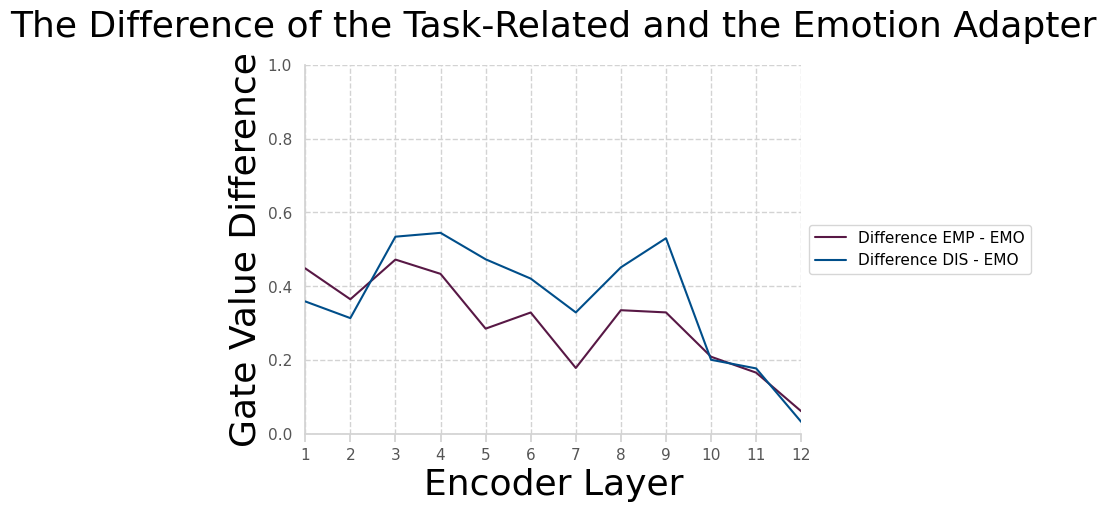

In [19]:
from turtle import color, pos


model_name = 'adapter_stack'
model_display_name = 'Adapter Stack 1e-4'
gates_emp = pd.read_csv(f'../output/{model_name}/empathy/gates.csv')
gates_dis = pd.read_csv(f'../output/{model_name}/distress/gates.csv')
mean_emp, std_emp = get_grouped_std_mean(gates_emp, 'test', display_df=False)
mean_dis, std_dis = get_grouped_std_mean(gates_dis, 'test', display_df=False)

# difference between empathy and distress for emotionstacking
mean_emp = mean_emp.rename(columns={"gate_adapter-empathy": "gate_adapter-task"})
mean_dis = mean_dis.rename(columns={"gate_adapter-distress": "gate_adapter-task"})
display(mean_emp - mean_dis)

# difference in task related adapter and emotion adapter
difference_emp = mean_emp['gate_adapter-task'] - mean_emp['gate_adapter-bert-base-uncased-pf-emotion']
difference_dis = mean_dis['gate_adapter-task'] - mean_dis['gate_adapter-bert-base-uncased-pf-emotion']
print('difference_emp')
display(difference_emp)
print('difference_dis')
display(difference_dis)

plt.grid(c=accent_color, linestyle='--', zorder=0) #, alpha=0.2 
plt.plot(difference_emp, label='Difference EMP - EMO', c=color_per_method('gate_adapter-empathy'), zorder=3)
plt.plot(difference_dis, label='Difference DIS - EMO', c=color_per_method('gate_adapter-distress'), zorder=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,1)
plt.xlim(0,11)
plt.xlabel('Encoder Layer')
plt.ylabel('Gate Value Difference')
plt.title(f'The Difference of the Task-Related and the Emotion Adapter', pad=20) #  pad=80
plt.xticks(np.array(range(0, 12)), labels=np.array(range(1, 13)))
plt.savefig(f'{output_dir}/{model_name}/{model_name}_difference_task_emo.pdf', bbox_inches='tight', dpi=plt.gcf().dpi)
#plt.close()

# Error Analysis of the outcome

## Load the data

In [62]:
model_name = 'adapter_stack'#'unipelt_apl_1e-4'
task_name = 'distress'
model_dir = output_dir + model_name + f'/{task_name}/'
file_name = 'eval_gates_w_ids.csv'
gates_ids = pd.read_csv(model_dir + file_name, index_col=0, header=0)
gates_ids

,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress,encoder_layer,epoch,split,is_in_train,message_id,label
0,0.557714,0.918390,0,15.0,test,False,R_3QLVVnAgRBRH41U_1,1.000000
171,0.594172,0.930986,0,15.0,test,False,R_3QLVVnAgRBRH41U_2,0.437500
172,0.560302,0.906862,0,15.0,test,False,R_3QLVVnAgRBRH41U_3,0.354167
173,0.580505,0.912118,0,15.0,test,False,R_3QLVVnAgRBRH41U_4,0.166667
174,0.589206,0.930402,0,15.0,test,False,R_3QLVVnAgRBRH41U_5,0.604167
...,...,...,...,...,...,...,...,...
3065,0.685202,0.766027,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_1,0.208333
3066,0.666349,0.705583,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_2,0.770833
3067,0.677320,0.679699,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_3,0.229167
3053,0.701117,0.707817,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_4,0.062500


## Load and Map articles on the data based on message ID

In [63]:
# the news articles
articles = utils.load_articles(data_root_folder="../data/")
# dev and train data
data_train, data_dev = utils.load_data(data_root_folder="../data/")
data_dev['message_id']

0      R_3QLVVnAgRBRH41U_1
1      R_3QLVVnAgRBRH41U_2
2      R_3QLVVnAgRBRH41U_3
3      R_3QLVVnAgRBRH41U_4
4      R_3QLVVnAgRBRH41U_5
              ...         
265    R_r3CoQ7YjIwxVvJT_1
266    R_r3CoQ7YjIwxVvJT_2
267    R_r3CoQ7YjIwxVvJT_3
268    R_r3CoQ7YjIwxVvJT_4
269    R_r3CoQ7YjIwxVvJT_5
Name: message_id, Length: 270, dtype: object

In [64]:
shorten_data_dev = data_dev[['message_id', 'essay', 'empathy', 'distress', 'article_id', 'emotion']]
shorten_data_dev = shorten_data_dev.set_index('message_id')

joined_data = gates_ids.join(shorten_data_dev, on='message_id', how='left')
joined_data

,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress,encoder_layer,epoch,split,is_in_train,message_id,label,essay,empathy,distress,article_id,emotion
0,0.557714,0.918390,0,15.0,test,False,R_3QLVVnAgRBRH41U_1,1.000000,The story about the air strikes is very sadden...,7.000,7.000,13,sadness
171,0.594172,0.930986,0,15.0,test,False,R_3QLVVnAgRBRH41U_2,0.437500,It is clear that climate change is something t...,3.167,3.625,127,sadness
172,0.560302,0.906862,0,15.0,test,False,R_3QLVVnAgRBRH41U_3,0.354167,I did not know this comedian but thinking abou...,4.500,3.125,188,fear
173,0.580505,0.912118,0,15.0,test,False,R_3QLVVnAgRBRH41U_4,0.166667,I am an affirmed believer that your punishment...,2.000,2.000,307,anger
174,0.589206,0.930402,0,15.0,test,False,R_3QLVVnAgRBRH41U_5,0.604167,"Okay, I hate hearing about disease outbreaks. ...",4.500,4.625,409,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3065,0.685202,0.766027,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_1,0.208333,"While I feel bad for the arrest charges, I don...",2.000,2.250,2,anger
3066,0.666349,0.705583,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_2,0.770833,This is such a tragedy. All I can think about...,4.500,5.625,131,fear
3067,0.677320,0.679699,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_3,0.229167,I'm still on the fence regarding climate chang...,1.833,2.375,230,neutral
3053,0.701117,0.707817,11,15.0,test,False,R_r3CoQ7YjIwxVvJT_4,0.062500,I can understand why the Jewish community woul...,1.833,1.375,326,joy


### Does the emotion have influence on the gate value?

In [77]:
gating_cols = [col for col in joined_data.columns if 'gate' in col]
gate_per_emotion = joined_data.groupby(['encoder_layer', 'emotion']).agg({col: 'mean' for col in gating_cols})
mins = []
max = []
# show them for each layer
for i in range(12):
    display(gate_per_emotion.loc[i])
    gate_per_emotion_i = gate_per_emotion.loc[i]
    display(gate_per_emotion_i - gate_per_emotion_i.mean())
    mins.append((gate_per_emotion_i - gate_per_emotion_i.mean()).abs().min())
    max.append((gate_per_emotion_i - gate_per_emotion_i.mean()).abs().max())
    print((gate_per_emotion_i - gate_per_emotion_i.mean()).abs().min())
    print((gate_per_emotion_i - gate_per_emotion_i.mean()).abs().max())

print(max)
print(mins)


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.553097,0.912625
disgust,0.553123,0.914884
fear,0.548120,0.909551
joy,0.559824,0.914521
neutral,0.550388,0.912860
sadness,0.560252,0.915391
surprise,0.559557,0.917586


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,-0.001812,-0.001292
disgust,-0.001786,0.000968
fear,-0.006789,-0.004366
joy,0.004915,0.000604
neutral,-0.004520,-0.001057
sadness,0.005343,0.001474
surprise,0.004649,0.003669


gate_adapter-bert-base-uncased-pf-emotion    0.001786
gate_adapter-distress                        0.000604
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.006789
gate_adapter-distress                        0.004366
dtype: float64


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.593764,0.911175
disgust,0.597897,0.904523
fear,0.592725,0.907156
joy,0.594082,0.913321
neutral,0.596894,0.906111
sadness,0.595268,0.911216
surprise,0.596813,0.914276


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,-0.001585,0.001493
disgust,0.002548,-0.005160
fear,-0.002624,-0.002527
joy,-0.001267,0.003639
neutral,0.001545,-0.003572
sadness,-0.000081,0.001533
surprise,0.001464,0.004593


gate_adapter-bert-base-uncased-pf-emotion    0.000081
gate_adapter-distress                        0.001493
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.002624
gate_adapter-distress                        0.005160
dtype: float64


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.376552,0.916169
disgust,0.381224,0.912718
fear,0.380306,0.915043
joy,0.372668,0.919969
neutral,0.376466,0.915513
sadness,0.378680,0.916465
surprise,0.369777,0.919524


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.000027,-0.000317
disgust,0.004699,-0.003768
fear,0.003781,-0.001443
joy,-0.003856,0.003483
neutral,-0.000059,-0.000973
sadness,0.002155,-0.000020
surprise,-0.006748,0.003038


gate_adapter-bert-base-uncased-pf-emotion    0.000027
gate_adapter-distress                        0.000020
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.006748
gate_adapter-distress                        0.003768
dtype: float64


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.314567,0.860547
disgust,0.317883,0.855519
fear,0.309519,0.863119
joy,0.306442,0.867951
neutral,0.321749,0.858624
sadness,0.310433,0.862076
surprise,0.306321,0.867597


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.002151,-0.001658
disgust,0.005467,-0.006685
fear,-0.002898,0.000914
joy,-0.005974,0.005746
neutral,0.009333,-0.003580
sadness,-0.001983,-0.000129
surprise,-0.006095,0.005392


gate_adapter-bert-base-uncased-pf-emotion    0.001983
gate_adapter-distress                        0.000129
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.009333
gate_adapter-distress                        0.006685
dtype: float64


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.437993,0.914562
disgust,0.441100,0.912189
fear,0.445248,0.913396
joy,0.431814,0.917786
neutral,0.439172,0.915345
sadness,0.435484,0.915165
surprise,0.441744,0.916362


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,-0.000944,-0.000410
disgust,0.002164,-0.002783
fear,0.006312,-0.001576
joy,-0.007122,0.002814
neutral,0.000236,0.000373
sadness,-0.003452,0.000193
surprise,0.002807,0.001390


gate_adapter-bert-base-uncased-pf-emotion    0.000236
gate_adapter-distress                        0.000193
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.007122
gate_adapter-distress                        0.002814
dtype: float64


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.454608,0.875444
disgust,0.465208,0.874513
fear,0.448619,0.876752
joy,0.447650,0.877802
neutral,0.459502,0.875369
sadness,0.447440,0.877793
surprise,0.452700,0.878762


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.000933,-0.001189
disgust,0.011533,-0.002120
fear,-0.005056,0.000118
joy,-0.006025,0.001168
neutral,0.005826,-0.001265
sadness,-0.006236,0.001160
surprise,-0.000975,0.002128


gate_adapter-bert-base-uncased-pf-emotion    0.000933
gate_adapter-distress                        0.000118
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.011533
gate_adapter-distress                        0.002128
dtype: float64


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.566233,0.898071
disgust,0.567282,0.893370
fear,0.568988,0.900975
joy,0.557145,0.905960
neutral,0.566620,0.898094
sadness,0.569536,0.898581
surprise,0.567919,0.904682


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,-0.000013,-0.001891
disgust,0.001036,-0.006592
fear,0.002742,0.001013
joy,-0.009101,0.005999
neutral,0.000374,-0.001868
sadness,0.003290,-0.001381
surprise,0.001673,0.004720


gate_adapter-bert-base-uncased-pf-emotion    0.000013
gate_adapter-distress                        0.001013
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.009101
gate_adapter-distress                        0.006592
dtype: float64


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.426070,0.881107
disgust,0.429546,0.873038
fear,0.428779,0.875068
joy,0.418744,0.878509
neutral,0.427196,0.878973
sadness,0.421938,0.878877
surprise,0.423234,0.881282


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.000998,0.002985
disgust,0.004474,-0.005084
fear,0.003706,-0.003054
joy,-0.006328,0.000387
neutral,0.002124,0.000851
sadness,-0.003135,0.000755
surprise,-0.001839,0.003160


gate_adapter-bert-base-uncased-pf-emotion    0.000998
gate_adapter-distress                        0.000387
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.006328
gate_adapter-distress                        0.005084
dtype: float64


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.321154,0.853221
disgust,0.330943,0.855949
fear,0.315743,0.853431
joy,0.327224,0.855714
neutral,0.330342,0.856436
sadness,0.322155,0.853262
surprise,0.315013,0.855449


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,-0.002070,-0.001559
disgust,0.007718,0.001168
fear,-0.007482,-0.001349
joy,0.003999,0.000933
neutral,0.007117,0.001656
sadness,-0.001070,-0.001518
surprise,-0.008212,0.000669


gate_adapter-bert-base-uncased-pf-emotion    0.001070
gate_adapter-distress                        0.000669
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.008212
gate_adapter-distress                        0.001656
dtype: float64


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.591802,0.794666
disgust,0.596716,0.789823
fear,0.587744,0.794249
joy,0.593394,0.800174
neutral,0.590013,0.794465
sadness,0.596648,0.802394
surprise,0.607153,0.794808


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,-0.002980,-0.001131
disgust,0.001935,-0.005975
fear,-0.007037,-0.001548
joy,-0.001387,0.004377
neutral,-0.004768,-0.001332
sadness,0.001866,0.006596
surprise,0.012372,-0.000989


gate_adapter-bert-base-uncased-pf-emotion    0.001387
gate_adapter-distress                        0.000989
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.012372
gate_adapter-distress                        0.006596
dtype: float64


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.522579,0.690502
disgust,0.515352,0.707571
fear,0.519606,0.699708
joy,0.526099,0.702556
neutral,0.518616,0.700318
sadness,0.521294,0.688096
surprise,0.518483,0.688302


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.002289,-0.006220
disgust,-0.004938,0.010850
fear,-0.000684,0.002986
joy,0.005810,0.005834
neutral,-0.001674,0.003596
sadness,0.001004,-0.008626
surprise,-0.001807,-0.008419


gate_adapter-bert-base-uncased-pf-emotion    0.000684
gate_adapter-distress                        0.002986
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.00581
gate_adapter-distress                        0.01085
dtype: float64


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.692133,0.721595
disgust,0.696547,0.731285
fear,0.692889,0.719031
joy,0.689244,0.720940
neutral,0.691132,0.728798
sadness,0.687700,0.728229
surprise,0.694877,0.725458


,gate_adapter-bert-base-uncased-pf-emotion,gate_adapter-distress
emotion,,
anger,0.000058,-0.003453
disgust,0.004473,0.006237
fear,0.000814,-0.006017
joy,-0.002831,-0.004108
neutral,-0.000942,0.003750
sadness,-0.004374,0.003181
surprise,0.002802,0.000410


gate_adapter-bert-base-uncased-pf-emotion    0.000058
gate_adapter-distress                        0.000410
dtype: float64
gate_adapter-bert-base-uncased-pf-emotion    0.004473
gate_adapter-distress                        0.006237
dtype: float64
[gate_adapter-bert-base-uncased-pf-emotion    0.006789
gate_adapter-distress                        0.004366
dtype: float64, gate_adapter-bert-base-uncased-pf-emotion    0.002624
gate_adapter-distress                        0.005160
dtype: float64, gate_adapter-bert-base-uncased-pf-emotion    0.006748
gate_adapter-distress                        0.003768
dtype: float64, gate_adapter-bert-base-uncased-pf-emotion    0.009333
gate_adapter-distress                        0.006685
dtype: float64, gate_adapter-bert-base-uncased-pf-emotion    0.007122
gate_adapter-distress                        0.002814
dtype: float64, gate_adapter-bert-base-uncased-pf-emotion    0.011533
gate_adapter-distress                        0.002128
dtype: float64, gate_adap